Connected to tf-2.10 (Python 3.10.18)

# DrugComb Synergy Project — Final EDA & Modeling Notebook

**Goal is to investigate and connect additional fingerprint data and Omics to the DrugCombDB dataset, to explore whether a merged dataset with both chemistry and biology would provide better insights in synergy predictions.**

**Purpose.** This notebook is the *final* analysis pass using a merged table with:
- canonicalized drug pairs (`drug_min`, `drug_max`, `pair_id`)
- **ZIP** synergy as target (other scales optional)
- **Fingerprints** (PCA-reduced): `min_fp_pca_*`, `max_fp_pca_*`
- **Omics** latents (DepMap RNA): `sc_rna_latent*`
- **Tissue** one-hots: `sc_tissue_*`
- Basic **frequency** covariates: `*_freq` (+ log)

**Data processing.**
- Replicates aggregated per `(drug_min, drug_max, cell_line)` by mean.
- Winsorized synergy at 0.5%/99.5% to reduce outliers.
- **No leakage**: targets are never used as inputs.
- Normalized drug names
- 

**Tasks in this notebook.**
1. Sanity checks & coverage
2. Correlations and distributions
3. Regression baselines (HistGBR, RF)
4. Optional DL regressor/classifier
5. UMAP / clustering visualization
6. (Optional) Classification with ZIP cutoffs (+10/−10)
7. Simple ensembling and export


In [1]:
import os, time, warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GroupShuffleSplit, GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore", category=UserWarning)

# ---- Paths
PATH_CSV_MASTER = r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\master_fpPCA128_omics.csv"
OUT_DIR = Path(r"C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\notebook_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Globals
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---- Cutoffs for classification later
POS_CUTOFF, NEG_CUTOFF = 10, -10     # >10 synergistic, <-10 antagonistic, else neutral

[INFO] Dataset shape: (178024, 346)
          drug_min      drug_max cell_line  synergy_zip  synergy_bliss  \
0  (+)-bicuculline  temozolomide      t98g       21.850         21.850   
1          (+)-jq1    10356-76-0     u-ho1        3.590          1.960   
2          (+)-jq1  1088965-37-0     u-ho1        0.265         -2.555   

   synergy_loewe  synergy_hsa                       pair_id  synergy_mean  \
0          4.440        4.440  (+)-bicuculline_temozolomide      13.14500   
1         -4.015        2.770            (+)-jq1_10356-76-0       1.07625   
2         -8.925       -6.145          (+)-jq1_1088965-37-0      -4.34000   

   synergy_std  ...  sc_tissue_Liver  sc_tissue_Lung  sc_tissue_Lymphoid  \
0    10.051668  ...        -0.017238       -0.417171           -0.214432   
1     3.458784  ...        -0.017238       -0.417171            4.663481   
2     4.027923  ...        -0.017238       -0.417171            4.663481   

   sc_tissue_Myeloid  sc_tissue_Ovary/Fallopian Tube 

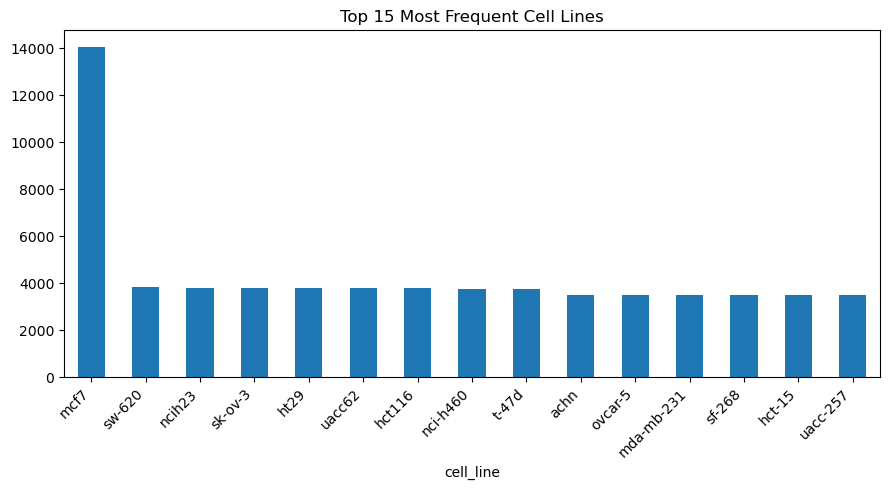


[Missing values > 0]
 min_fp_pca_0     382
min_fp_pca_65    382
min_fp_pca_96    382
min_fp_pca_94    382
min_fp_pca_93    382
min_fp_pca_92    382
min_fp_pca_91    382
min_fp_pca_90    382
min_fp_pca_89    382
min_fp_pca_88    382
min_fp_pca_87    382
min_fp_pca_86    382
min_fp_pca_85    382
min_fp_pca_84    382
min_fp_pca_83    382
min_fp_pca_82    382
min_fp_pca_81    382
min_fp_pca_80    382
min_fp_pca_79    382
min_fp_pca_78    382
dtype: int64

[Totals] NaN: 81408 | zeros: 174060


In [2]:
df = pd.read_csv(PATH_CSV_MASTER)

print("[INFO] Dataset shape:", df.shape)
print(df.head(3))
print("\n[INFO] Dtypes (first 20):")
print(df.dtypes.head(20))

print("\n[INFO] Basic stats (numeric):")
print(df.describe().T.head(15))

# Cell line frequency
if "cell_line" in df.columns:
    cell_counts = df["cell_line"].value_counts()
    print("\n[INFO] Total unique cell lines:", len(cell_counts))
    print("[Top 15 cell lines]\n", cell_counts.head(15))
    plt.figure(figsize=(9,5))
    cell_counts.head(15).plot(kind="bar")
    plt.title("Top 15 Most Frequent Cell Lines")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# Missing values overview
na_per_col = df.isnull().sum()
print("\n[Missing values > 0]\n", na_per_col[na_per_col > 0].sort_values(ascending=False).head(20))
print("\n[Totals] NaN:", int(df.isna().sum().sum()), "| zeros:", int((df == 0).sum().sum()))

In [3]:
fp_cols = [c for c in df.columns if c.startswith("min_fp_pca_") or c.startswith("max_fp_pca_")]
if len(fp_cols) == 0:
    raise RuntimeError("Fingerprint PCA columns not found (min_fp_pca_*/max_fp_pca_*).")

mask_missing_fp = df[fp_cols].isna().any(axis=1)
dropped_rows = df[mask_missing_fp]

dropped_summary = (
    dropped_rows[["drug_min", "drug_max"]]
    .melt(value_name="drug")["drug"]
    .value_counts()
    .reset_index().rename(columns={"index":"drug", "drug":"count"})
)

print(f"[ACTION] Dropping rows with missing FP: {len(dropped_rows)} ({100*len(dropped_rows)/len(df):.2f}%)")
print("[INFO] Dropped drugs (freq):")
print(dropped_summary.head(25))

dropped_path = OUT_DIR / "dropped_drugs.csv"
dropped_summary.to_csv(dropped_path, index=False)
print(f"[OK] Saved dropped drug summary → {dropped_path}")

df = df[~mask_missing_fp].reset_index(drop=True)
print("[OK] New shape after FP drop:", df.shape)

[ACTION] Dropping rows with missing FP: 615 (0.35%)
[INFO] Dropped drugs (freq):
                                                count  count
0                                            ak-77283    130
1                                            ak170455    108
2                                         717906-29-1     79
3   2-methoxy-3,17beta-dihydroxyestra-1,3,5(10)-tr...     67
4                                            ac1l2qk3     67
5                                        zinc34894448     55
6                                        zinc17545571     52
7                                         ruxolitinib     50
8                                         verteporfin     28
9                                   bgt-226 free base     12
10                                 bardoxolone methyl     11
11                             crenolanib (cp-868596)     10
12                                      chembl3348931     10
13                               abt-263 (navitoclax)     10
14  

In [4]:
for c in ["synergy_bliss", "synergy_loewe", "synergy_hsa", "synergy_mean", "synergy_binary", "synergy_std"]:
    if c in df.columns:
        df = df.drop(columns=[c])
        print(f"[ACTION] Dropped: {c}")

print("[OK] Shape after drops:", df.shape)

[ACTION] Dropped: synergy_bliss
[ACTION] Dropped: synergy_loewe
[ACTION] Dropped: synergy_hsa
[ACTION] Dropped: synergy_mean
[ACTION] Dropped: synergy_binary
[ACTION] Dropped: synergy_std
[OK] Shape after drops: (177409, 340)



[Top +corr to synergy_zip]
 synergy_zip              1.000000
sc_tissue_Lymphoid       0.189875
min_fp_pca_0             0.133732
sc_tissue_Bone           0.124521
min_fp_pca_51            0.107804
min_fp_pca_106           0.087916
min_fp_pca_47            0.087209
sc_tissue_Soft Tissue    0.087171
max_fp_pca_0             0.086999
min_fp_pca_60            0.085903
min_fp_pca_88            0.082373
min_fp_pca_11            0.080525
min_fp_pca_13            0.078982
max_fp_pca_121           0.078799
min_fp_pca_1             0.077444
Name: synergy_zip, dtype: float64

[Top -corr to synergy_zip]
 min_fp_pca_5        -0.070302
min_fp_pca_35       -0.070972
min_fp_pca_93       -0.073661
min_fp_pca_10       -0.074421
min_fp_pca_28       -0.075514
max_fp_pca_35       -0.076444
max_fp_pca_23       -0.077840
max_fp_pca_32       -0.078686
min_fp_pca_18       -0.082651
min_fp_pca_7        -0.121649
drug_max_freq_log   -0.160407
cell_freq_log       -0.163152
cell_freq           -0.194213
drug_min

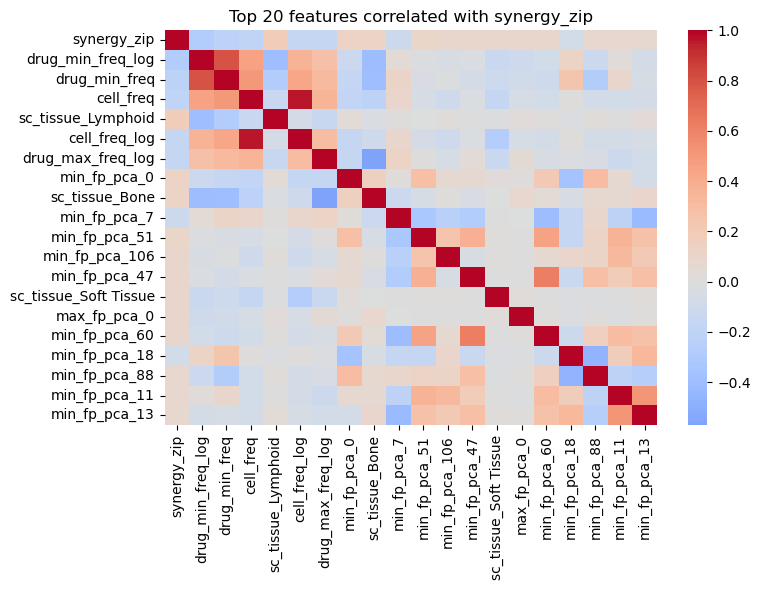

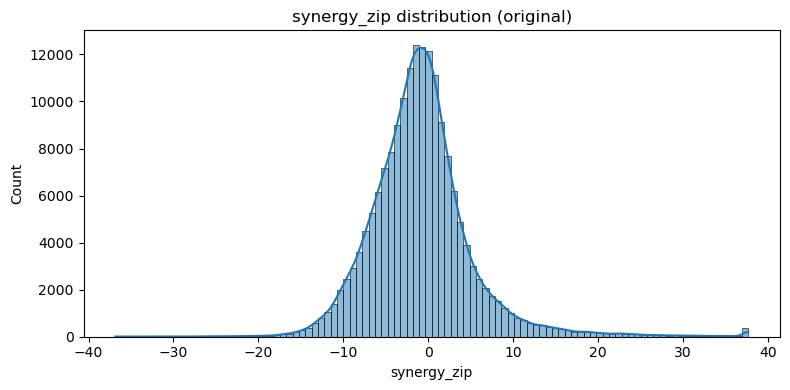

In [5]:
if "synergy_zip" not in df.columns:
    raise RuntimeError("Missing 'synergy_zip' column.")

corr = df.corr(numeric_only=True)["synergy_zip"].sort_values(ascending=False)
print("\n[Top +corr to synergy_zip]\n", corr.head(15))
print("\n[Top -corr to synergy_zip]\n", corr.tail(15))

top_feats = corr.abs().sort_values(ascending=False).head(20).index
plt.figure(figsize=(8,6))
sns.heatmap(df[top_feats].corr(), cmap="coolwarm", center=0, cbar=True)
plt.title("Top 20 features correlated with synergy_zip")
plt.tight_layout(); plt.show()

# Target distribution
plt.figure(figsize=(8,4))
sns.histplot(df["synergy_zip"], bins=100, kde=True)
plt.title("synergy_zip distribution (original)")
plt.tight_layout(); plt.show()

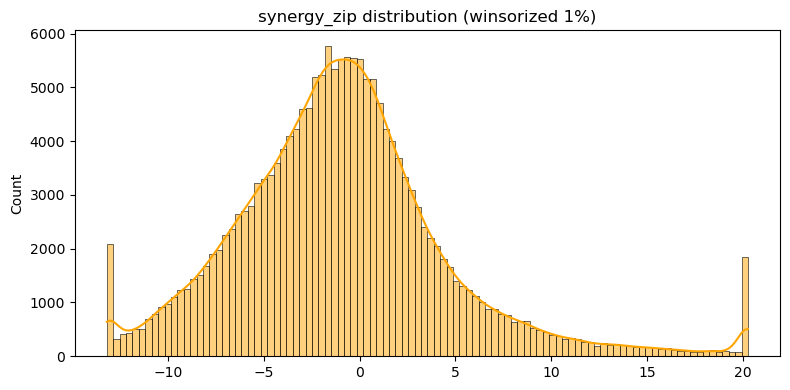

In [6]:
from scipy.stats.mstats import winsorize
wins = winsorize(df["synergy_zip"], limits=[0.01, 0.01])
plt.figure(figsize=(8,4))
sns.histplot(wins, bins=100, kde=True, color="orange")
plt.title("synergy_zip distribution (winsorized 1%)")
plt.tight_layout(); plt.show()

In [7]:
# Build feature set used in classical regressors / UMAP
feat_cols = [c for c in df.columns if (
    c.startswith("min_fp_pca_") or
    c.startswith("max_fp_pca_") or
    c.startswith("sc_rna_latent") or
    c.startswith("sc_tissue_") or
    ("freq" in c)   # e.g. drug_min_freq, *_freq_log
)]

work = df.dropna(subset=feat_cols + ["synergy_zip"]).copy()

VAL_SIZE = 0.20
SUBSAMPLE_SIZE = 100_000
MAX_BINS = 5
MIN_PER_CLASS = 2

strat_cell_col = "cell_line" if "cell_line" in work.columns else ("cell_id" if "cell_id" in work.columns else None)
if strat_cell_col is None:
    work["__cell_fallback__"] = "all"
    strat_cell_col = "__cell_fallback__"

def try_make_splits(work, n_bins):
    w = work.copy()
    w["synergy_bin"] = pd.qcut(w["synergy_zip"], q=n_bins, labels=False, duplicates="drop")
    strat_key = w[strat_cell_col].astype(str) + "|" + w["synergy_bin"].astype(str)

    counts = strat_key.value_counts()
    keep_keys = counts[counts >= MIN_PER_CLASS].index
    w2 = w.loc[strat_key.isin(keep_keys)].copy()
    strat2 = strat_key.loc[strat_key.isin(keep_keys)]

    n_classes = strat2.nunique()
    train_size = int((1 - VAL_SIZE) * len(w2))
    if train_size < n_classes:
        return None

    tr_idx, va_idx = train_test_split(w2.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=strat2)
    train_df = w2.loc[tr_idx].copy()
    val_df = w2.loc[va_idx].copy()

    sub_size = min(SUBSAMPLE_SIZE, len(train_df))
    sub_key = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))
    sub_counts = sub_key.value_counts()
    train_df = train_df.loc[sub_key.isin(sub_counts[sub_counts >= MIN_PER_CLASS].index)].copy()
    sub_key = (train_df[strat_cell_col].astype(str) + "|" + train_df["synergy_bin"].astype(str))
    n_cls_sub = sub_key.nunique()

    if sub_size < n_cls_sub:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=sub_size, random_state=RANDOM_SEED)
        for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
            sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)
    else:
        sub_df, _ = train_test_split(train_df, train_size=sub_size, random_state=RANDOM_SEED, stratify=sub_key)
        sub_df = sub_df.reset_index(drop=True)

    return sub_df, val_df, n_bins, w2

result = None
for nb in range(MAX_BINS, 1, -1):
    result = try_make_splits(work, nb)
    if result is not None:
        sub_df, val_df, used_bins, filtered_work = result
        print(f"[INFO] Stratified OK with n_bins={used_bins} | train_sub={len(sub_df):,} | val={len(val_df):,} | after filter: {len(filtered_work):,}")
        break

if result is None:
    print("[WARN] Fallback: stratify by target bins only.")
    work["synergy_bin"] = pd.qcut(work["synergy_zip"], q=3, labels=False, duplicates="drop")
    tr_idx, va_idx = train_test_split(work.index, test_size=VAL_SIZE, random_state=RANDOM_SEED, stratify=work["synergy_bin"])
    train_df = work.loc[tr_idx].copy(); val_df = work.loc[va_idx].copy()
    sss = StratifiedShuffleSplit(n_splits=1, train_size=min(SUBSAMPLE_SIZE, len(train_df)), random_state=RANDOM_SEED)
    for sub_tr_idx, _ in sss.split(train_df, train_df["synergy_bin"]):
        sub_df = train_df.iloc[sub_tr_idx].reset_index(drop=True)

print(f"[OK] Train SUB shape: {sub_df.shape} | VAL shape: {val_df.shape}")

[INFO] Stratified OK with n_bins=5 | train_sub=100,000 | val=35,481 | after filter: 177,405
[OK] Train SUB shape: (100000, 341) | VAL shape: (35481, 341)


In [ ]:
X_sub = sub_df[feat_cols].fillna(0).to_numpy(np.float32)
y_sub = sub_df["synergy_zip"].to_numpy(np.float32)
X_val = val_df[feat_cols].fillna(0).to_numpy(np.float32)
y_val = val_df["synergy_zip"].to_numpy(np.float32)

# HistGBR
hgb = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.08, max_iter=400,
    min_samples_leaf=20, l2_regularization=1e-3, random_state=RANDOM_SEED
)
hgb.fit(X_sub, y_sub)
pred_val = hgb.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val)
rmse = float(np.sqrt(np.mean((y_val - pred_val)**2)))
r2   = r2_score(y_val, pred_val)
r    = float(np.corrcoef(y_val, pred_val)[0,1])
print(f"[HistGBR] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

perm = permutation_importance(hgb, X_val, y_val, n_repeats=5, random_state=RANDOM_SEED, n_jobs=-1)
imp_hgb_perm = pd.Series(perm.importances_mean, index=feat_cols).clip(lower=0)
imp_hgb_perm_n = imp_hgb_perm / (imp_hgb_perm.max() + 1e-12)

topN = 20
plt.figure(figsize=(9,7))
imp_hgb_perm_n.sort_values(ascending=False).head(topN).iloc[::-1].plot(kind="barh")
plt.title("HistGBR Permutation Importance (validation) — Top 20")
plt.tight_layout(); plt.show()

# RandomForest
rf = RandomForestRegressor(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    n_jobs=-1, random_state=RANDOM_SEED
)
rf.fit(X_sub, y_sub)
pred_val_rf = rf.predict(X_val)
mae  = mean_absolute_error(y_val, pred_val_rf)
rmse = float(np.sqrt(np.mean((y_val - pred_val_rf)**2)))
r2   = r2_score(y_val, pred_val_rf)
r    = float(np.corrcoef(y_val, pred_val_rf)[0,1])
print(f"[RandomForest] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

c:\Users\46762\VSCODE\conda\envs\tf-2.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[OK] Saved UMAP embeddings → C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\notebook_outputs\umap_cpu_cosine_n20_d0.20_embeddings.csv


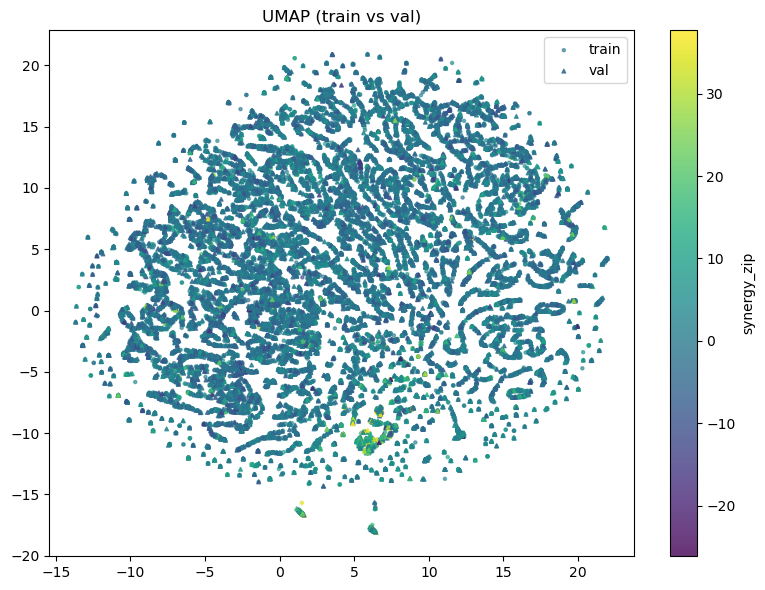

[WARN] trustworthiness failed: Unable to allocate 37.3 GiB for an array with shape (100000, 100000) and data type float32


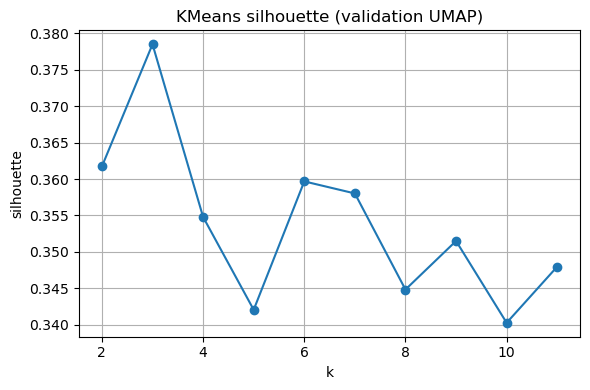

[INFO] Best silhouette at k=3 (val)
[INFO] DBSCAN islands (val): 65 (label -1 = noise)

[Island summary] (top by mean)
 island  count      mean    median      max top_cell  top_cell_share
     21     24 13.793272  7.748333 37.67704    u-ho1        0.791667
     20    127 10.939230 10.980000 37.67704     t98g        1.000000
     17    211  8.942809  5.560000 37.67704   l-1236        1.000000
     14    529  8.783841  7.660000 37.67704    tc-71        0.432892
     30     24  7.220417  5.495000 16.15250   skmes1        0.125000
     40     93  5.502138  4.195000 37.67704    u-ho1        0.258065
     58     46  4.144946  3.632500 21.94000     t98g        0.304348
     59     24  3.874583  4.477500 17.28000 ncih1650        0.125000
     29     26  3.834391  4.250833 27.45800    u-ho1        0.807692
     46    194  3.418005  2.472917 37.67704    a-673        0.185567


In [ ]:
try:
    from umap import UMAP
except ImportError as e:
    raise ImportError("Please install umap-learn first: pip install umap-learn") from e

try:
    from sklearn.manifold import trustworthiness
    HAS_TRUST = True
except Exception:
    HAS_TRUST = False

UMAP_METRIC = "cosine"
umap_model = UMAP(n_neighbors=20, min_dist=0.20, n_components=2,
                  metric=UMAP_METRIC, random_state=RANDOM_SEED, low_memory=True)
Z_sub = umap_model.fit_transform(X_sub)
Z_val = umap_model.transform(X_val)

# Save embeddings
emb_train = pd.DataFrame(Z_sub, columns=["z1","z2"], dtype=np.float32)
emb_train["split"] = "train"; emb_train["synergy_zip"] = y_sub
emb_val = pd.DataFrame(Z_val, columns=["z1","z2"], dtype=np.float32)
emb_val["split"] = "val"; emb_val["synergy_zip"] = y_val
embs = pd.concat([emb_train, emb_val], ignore_index=True)
emb_path = OUT_DIR / f"umap_cpu_{UMAP_METRIC}_n20_d0.20_embeddings.csv"
embs.to_csv(emb_path, index=False)
print(f"[OK] Saved UMAP embeddings → {emb_path}")

# Plot overlay train/val
rng = np.random.RandomState(0)
idx_tr = rng.choice(len(Z_sub), size=min(15000, len(Z_sub)), replace=False)
idx_va = rng.choice(len(Z_val), size=min(15000, len(Z_val)), replace=False)
plt.figure(figsize=(8,6))
plt.scatter(Z_sub[idx_tr,0], Z_sub[idx_tr,1], c=y_sub[idx_tr], s=5, alpha=0.6, cmap="viridis", label="train")
plt.scatter(Z_val[idx_va,0], Z_val[idx_va,1], c=y_val[idx_va], s=7, alpha=0.8, cmap="viridis", marker="^", label="val")
plt.colorbar(label="synergy_zip")
plt.title("UMAP (train vs val)")
plt.legend(); plt.tight_layout(); plt.show()

if HAS_TRUST:
    try:
        trust_tr  = float(trustworthiness(X_sub, Z_sub, n_neighbors=15, metric="euclidean"))
        trust_val = float(trustworthiness(X_val, Z_val, n_neighbors=15, metric="euclidean"))
        print(f"[Trustworthiness] train={trust_tr:.3f} | val={trust_val:.3f}")
    except Exception as e:
        print("[WARN] trustworthiness failed:", e)

# KMeans silhouette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_RANGE = range(2, 12)
sil_scores = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_SEED)
    labels = km.fit_predict(Z_val)
    sil = silhouette_score(Z_val, labels) if len(np.unique(labels)) > 1 else np.nan
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.title("KMeans silhouette (validation UMAP)")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.grid(True); plt.tight_layout(); plt.show()

best_k = K_RANGE[int(np.nanargmax(sil_scores))]
print(f"[INFO] Best silhouette at k={best_k:.0f} (val)")

# DBSCAN islands on val for interpretation
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=20)
labels = db.fit_predict(Z_val)
val_df_ = val_df.copy()
val_df_["z1"] = Z_val[:,0]; val_df_["z2"] = Z_val[:,1]; val_df_["island"] = labels
n_islands = int(val_df_["island"].nunique() - (1 if -1 in labels else 0))
print(f"[INFO] DBSCAN islands (val): {n_islands} (label -1 = noise)")

# Island summary by mean synergy
rows = []
for isl, g in val_df_.groupby("island"):
    if isl == -1: continue
    cnt = len(g); mean = g["synergy_zip"].mean(); med = g["synergy_zip"].median(); mx = g["synergy_zip"].max()
    if "cell_line" in g.columns:
        top_cell = g["cell_line"].value_counts().idxmax(); share = g["cell_line"].value_counts(normalize=True).iloc[0]
    else:
        top_cell, share = None, np.nan
    rows.append({"island":isl,"count":cnt,"mean":mean,"median":med,"max":mx,"top_cell":top_cell,"top_cell_share":share})
isum = pd.DataFrame(rows).sort_values(["mean","count"], ascending=[False, False])
print("\n[Island summary] (top by mean)")
print(isum.head(10).to_string(index=False))

Epoch 1/40
98/98 [==============================] - 3s 11ms/step - loss: 27.9109 - val_loss: 25.9446 - lr: 0.0010
Epoch 2/40
98/98 [==============================] - 1s 8ms/step - loss: 24.4781 - val_loss: 24.5840 - lr: 0.0010
Epoch 3/40
98/98 [==============================] - 1s 8ms/step - loss: 22.6562 - val_loss: 23.2183 - lr: 0.0010
Epoch 4/40
98/98 [==============================] - 1s 8ms/step - loss: 21.2653 - val_loss: 22.5521 - lr: 0.0010
Epoch 5/40
98/98 [==============================] - 1s 8ms/step - loss: 19.9309 - val_loss: 22.0320 - lr: 0.0010
Epoch 6/40
98/98 [==============================] - 1s 8ms/step - loss: 18.8714 - val_loss: 21.9533 - lr: 0.0010
Epoch 7/40
98/98 [==============================] - 1s 8ms/step - loss: 17.7226 - val_loss: 22.0180 - lr: 0.0010
Epoch 8/40
98/98 [==============================] - 1s 8ms/step - loss: 17.0612 - val_loss: 21.1872 - lr: 0.0010
Epoch 9/40
98/98 [==============================] - 1s 7ms/step - loss: 16.3284 - val_loss: 20.

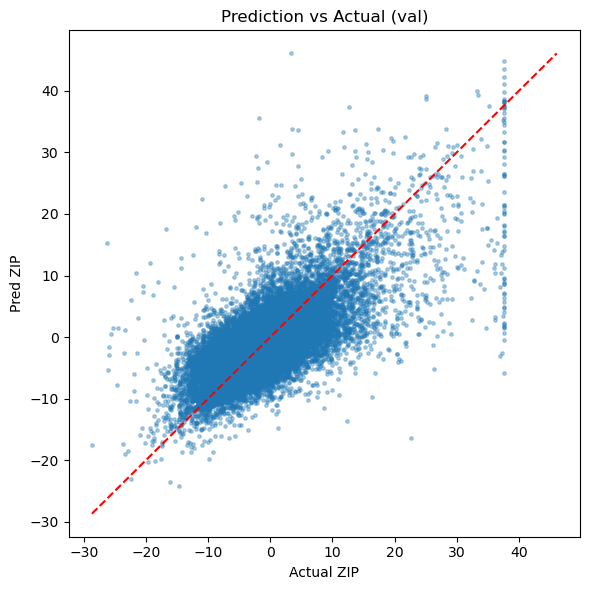

In [ ]:
# Comments in ENGLISH only (as requested)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

min_fp_cols = [c for c in feat_cols if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in feat_cols if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in feat_cols if c.startswith("sc_rna_latent")]
freq_cols   = [c for c in feat_cols if ("freq" in c and not c.startswith("min_fp_pca_") and not c.startswith("max_fp_pca_") and not c.startswith("sc_rna_latent"))]

assert len(min_fp_cols)>0 and len(max_fp_cols)>0, "Missing FP PCA columns."
assert len(rna_cols)>0, "Missing RNA latent columns (sc_rna_latent*)."

def to_np(df_block):
    X_min = df_block[min_fp_cols].fillna(0).to_numpy(np.float32)
    X_max = df_block[max_fp_cols].fillna(0).to_numpy(np.float32)
    X_rna = df_block[rna_cols].fillna(0).to_numpy(np.float32)
    X_frq = df_block[freq_cols].fillna(0).to_numpy(np.float32) if len(freq_cols) else None
    y     = df_block["synergy_zip"].to_numpy(np.float32)
    return X_min, X_max, X_rna, X_frq, y

Xmin_tr, Xmax_tr, Xrna_tr, Xfrq_tr, y_tr = to_np(sub_df)
Xmin_va, Xmax_va, Xrna_va, Xfrq_va, y_va = to_np(val_df)

sc_min = StandardScaler().fit(Xmin_tr); Xmin_tr = sc_min.transform(Xmin_tr); Xmin_va = sc_min.transform(Xmin_va)
sc_max = StandardScaler().fit(Xmax_tr); Xmax_tr = sc_max.transform(Xmax_tr); Xmax_va = sc_max.transform(Xmax_va)
sc_rna = StandardScaler().fit(Xrna_tr); Xrna_tr = sc_rna.transform(Xrna_tr); Xrna_va = sc_rna.transform(Xrna_va)
sc_frq = StandardScaler().fit(Xfrq_tr) if Xfrq_tr is not None else None
if Xfrq_tr is not None:
    Xfrq_tr = sc_frq.transform(Xfrq_tr); Xfrq_va = sc_frq.transform(Xfrq_va)

def build_shared_drug_encoder(input_dim, width=256, depth=2, name="drug_enc"):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

def build_cell_encoder(input_dim, width=256, depth=2, name="cell_enc"):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(width, activation="relu")(inp)
    for _ in range(depth-1):
        x = layers.Dense(width//2, activation="relu")(x)
    z = layers.Dense(64, activation=None, name=name+"_z")(x)
    return keras.Model(inp, z, name=name)

inp_min = keras.Input(shape=(Xmin_tr.shape[1],), name="min_fp")
inp_max = keras.Input(shape=(Xmax_tr.shape[1],), name="max_fp")
inp_rna = keras.Input(shape=(Xrna_tr.shape[1],), name="rna")
inp_frq = keras.Input(shape=(Xfrq_tr.shape[1],), name="freq") if Xfrq_tr is not None else None

drug_enc = build_shared_drug_encoder(Xmin_tr.shape[1], width=256, depth=2, name="drug_enc")
cell_enc = build_cell_encoder(Xrna_tr.shape[1], width=256, depth=2, name="cell_enc")

z_min = drug_enc(inp_min)
z_max = drug_enc(inp_max)
z_rna = cell_enc(inp_rna)

abs_diff   = layers.Lambda(lambda t: tf.abs(t[0]-t[1]))([z_min, z_max])
hadamard   = layers.Multiply()([z_min, z_max])
pair_sum   = layers.Add()([z_min, z_max])
pair_cell  = layers.Multiply()([pair_sum, z_rna])
pair_match = layers.Lambda(lambda t: tf.abs(t[0]-t[1]))([pair_sum, z_rna])

blocks = [z_min, z_max, abs_diff, hadamard, z_rna, pair_cell, pair_match]
if inp_frq is not None:
    frq_z = layers.Dense(16, activation="relu")(inp_frq)
    blocks.append(frq_z)

h = layers.Concatenate()(blocks)
h = layers.Dense(256, activation="relu")(h)
h = layers.Dense(128, activation="relu")(h)
out = layers.Dense(1, activation=None, name="synergy")(h)

inputs = [inp_min, inp_max, inp_rna] + ([inp_frq] if inp_frq is not None else [])
reg_model = keras.Model(inputs, out, name="HypothesisRegressor")
reg_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

cb = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]
train_in = [Xmin_tr, Xmax_tr, Xrna_tr] + ([Xfrq_tr] if Xfrq_tr is not None else [])
val_in   = [Xmin_va, Xmax_va, Xrna_va] + ([Xfrq_va] if Xfrq_va is not None else [])
hist = reg_model.fit(train_in, y_tr, validation_data=(val_in, y_va),
                     epochs=40, batch_size=1024, verbose=1, callbacks=cb)

pred_va = reg_model.predict(val_in, batch_size=4096, verbose=0).ravel()
mae  = mean_absolute_error(y_va, pred_va)
rmse = float(np.sqrt(np.mean((y_va - pred_va)**2)))
r2   = r2_score(y_va, pred_va)
r    = float(np.corrcoef(y_va, pred_va)[0,1]) if len(y_va)>1 else np.nan
print(f"[DL Regression] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_va, pred_va, s=6, alpha=0.35)
lims = [min(y_va.min(), pred_va.min()), max(y_va.max(), pred_va.max())]
plt.plot(lims, lims, 'r--'); plt.title("Prediction vs Actual (val)")
plt.xlabel("Actual ZIP"); plt.ylabel("Pred ZIP"); plt.tight_layout(); plt.show()

In [ ]:
# IMPORTANT: We create labels from synergy_zip. To avoid trivial leakage, we EXCLUDE synergy_zip as a model input.

BINARY_TARGET = False   # True: synergy vs rest; False: 3-class

df_cls = df.copy()
def zip_to_class(x):
    if pd.isna(x): return np.nan
    if x > POS_CUTOFF:   return "synergistic"
    elif x < NEG_CUTOFF: return "antagonistic"
    else:                return "neutral"

df_cls["synergy_class"] = df_cls["synergy_zip"].map(zip_to_class)
df_cls = df_cls.dropna(subset=["synergy_class"]).reset_index(drop=True)

# Build continuous feature blocks (no ZIP)
min_fp_cols = [c for c in df_cls.columns if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in df_cls.columns if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in df_cls.columns if c.startswith("sc_rna_latent")]
tissue_cols = [c for c in df_cls.columns if c.startswith("sc_tissue_")]
freq_cols   = [c for c in df_cls.columns if ("freq" in c and not c.startswith("min_fp_pca_") and not c.startswith("max_fp_pca_") and not c.startswith("sc_rna_latent"))]

# Input dict for Keras Functional API
X_all = {}
X_all["min_fp"] = df_cls[min_fp_cols].astype("float32").fillna(0).to_numpy()
X_all["max_fp"] = df_cls[max_fp_cols].astype("float32").fillna(0).to_numpy()
X_all["fp_hadamard"] = (X_all["min_fp"] * X_all["max_fp"]).astype("float32")
X_all["fp_absdiff"]  = np.abs(X_all["min_fp"] - X_all["max_fp"]).astype("float32")
if len(rna_cols):    X_all["rna"]    = df_cls[rna_cols].astype("float32").fillna(0).to_numpy()
if len(tissue_cols): X_all["tissue"] = df_cls[tissue_cols].astype("float32").fillna(0).to_numpy()
if len(freq_cols):   X_all["freq"]   = df_cls[freq_cols].astype("float32").fillna(0).to_numpy()

# Target
if BINARY_TARGET:
    y_all = df_cls["synergy_class"].map(lambda z: 1 if z=="synergistic" else 0).astype("int32").to_numpy()
else:
    mapping = {"antagonistic":0, "neutral":1, "synergistic":2}
    y_all = df_cls["synergy_class"].map(mapping).astype("int32").to_numpy()

# Groups to avoid leakage across identical (drug_min, drug_max, cell_line)
if {"drug_min","drug_max","cell_line"}.issubset(df_cls.columns):
    groups = (df_cls["drug_min"].astype(str) + "|" + df_cls["drug_max"].astype(str) + "|" + df_cls["cell_line"].astype(str))
else:
    # fallback if strings are not present
    groups = pd.Series(np.arange(len(df_cls)), dtype=str)

# Group-aware split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
idx = np.arange(len(df_cls))
tr_idx, te_idx = next(gss.split(idx, y_all, groups=groups))

def split_dict(Xd):
    return {k: v[tr_idx] for k,v in Xd.items()}, {k: v[te_idx] for k,v in Xd.items()}
Xtr, Xte = split_dict(X_all)
ytr, yte = y_all[tr_idx], y_all[te_idx]

# Standardize continuous blocks (recommended for DL)
scalers = {}
for name in ["min_fp","max_fp","fp_hadamard","fp_absdiff","rna","tissue","freq"]:
    if name in Xtr:
        sc = StandardScaler(with_mean=True, with_std=True)
        Xtr[name] = sc.fit_transform(Xtr[name])
        Xte[name] = sc.transform(Xte[name])
        scalers[name] = sc

# Build classifier model (multimodal towers)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = []
towers = []

def tower(name, x, units=[256,128], drop=0.25):
    for i, u in enumerate(units):
        x = layers.Dense(u, activation="relu", name=f"{name}_d{i}")(x)
        x = layers.Dropout(drop, name=f"{name}_do{i}")(x)
    return x

for name in ["min_fp","max_fp","fp_hadamard","fp_absdiff","rna","tissue","freq"]:
    if name in Xtr:
        inp = keras.Input(shape=(Xtr[name].shape[1],), dtype="float32", name=name)
        inputs.append(inp)
        towers.append(tower(name, inp, units=[256,128], drop=0.25))

fused = layers.Concatenate(name="fuse")(towers) if len(towers)>1 else towers[0]
x = fused
for i,u in enumerate([512,256,128]):
    x = layers.Dense(u, activation="relu", name=f"trunk_d{i}")(x)
    x = layers.Dropout(0.25, name=f"trunk_do{i}")(x)

if BINARY_TARGET:
    out = layers.Dense(1, activation="sigmoid", name="cls")(x)
    clf = keras.Model(inputs, out, name="DL_bin_classifier")
    clf.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
else:
    out = layers.Dense(3, activation="softmax", name="cls")(x)
    clf = keras.Model(inputs, out, name="DL_3class_classifier")
    clf.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Class weights
cw = {cls: len(ytr)/ (len(np.unique(ytr))*n) for cls, n in Counter(ytr.tolist()).items()}
cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
]

hist = clf.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=60, batch_size=1024, class_weight=cw, verbose=2, callbacks=cb)

# Evaluation
if BINARY_TARGET:
    y_prob = clf.predict(Xte, batch_size=4096).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    print("\n=== Classification Report (binary) ===")
    print(classification_report(yte, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))
    try:
        print(f"ROC-AUC: {roc_auc_score(yte, y_prob):.3f} | PR-AUC: {average_precision_score(yte, y_prob):.3f}")
    except Exception:
        pass
else:
    y_proba = clf.predict(Xte, batch_size=4096)
    y_pred = np.argmax(y_proba, axis=1)
    print("\n=== Classification Report (3-class) ===")
    print(classification_report(yte, y_pred, digits=3, target_names=["antagonistic","neutral","synergistic"]))
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))
    # Synergy-vs-rest AUCs (optional)
    try:
        pos_idx = 2  # synergistic
        y_bin = (yte == pos_idx).astype(int)
        print(f"Synergy ROC-AUC: {roc_auc_score(y_bin, y_proba[:,pos_idx]):.3f} | PR-AUC: {average_precision_score(y_bin, y_proba[:,pos_idx]):.3f}")
    except Exception:
        pass

# Save models (optional)
clf_path = OUT_DIR / ("dl_classifier_binary.keras" if BINARY_TARGET else "dl_classifier_3class.keras")
clf.save(clf_path); print(f"[OK] Saved classifier → {clf_path}")
reg_path = OUT_DIR / "dl_regressor.keras"
reg_model.save(reg_path); print(f"[OK] Saved regressor → {reg_path}")

Epoch 1/60
139/139 - 3s - loss: 0.8734 - accuracy: 0.5003 - val_loss: 0.9149 - val_accuracy: 0.5315 - lr: 0.0010 - 3s/epoch - 23ms/step
Epoch 2/60
139/139 - 2s - loss: 0.7455 - accuracy: 0.5562 - val_loss: 0.8304 - val_accuracy: 0.5742 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 3/60
139/139 - 2s - loss: 0.7054 - accuracy: 0.5641 - val_loss: 0.8213 - val_accuracy: 0.5453 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 4/60
139/139 - 2s - loss: 0.6726 - accuracy: 0.5735 - val_loss: 0.8472 - val_accuracy: 0.5223 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 5/60
139/139 - 2s - loss: 0.6439 - accuracy: 0.5835 - val_loss: 0.7406 - val_accuracy: 0.6081 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 6/60
139/139 - 2s - loss: 0.6216 - accuracy: 0.5955 - val_loss: 0.7350 - val_accuracy: 0.6340 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 7/60
139/139 - 2s - loss: 0.5982 - accuracy: 0.5966 - val_loss: 0.7687 - val_accuracy: 0.5627 - lr: 0.0010 - 2s/epoch - 12ms/step
Epoch 8/60
139/139 - 2s - loss: 0.5846 - accurac

 ## Notes & Next Steps
 - The DL regressor captures FP×FP and FP×Cell interactions explicitly (|diff|, Hadamard, pair×cell match).
 - The classifier uses labels from ZIP cutoffs; ensure ZIP is NOT used as input to avoid leakage.
 - Try different cutoffs (±5, ±15, ±20): stricter cutoffs → cleaner labels but fewer samples.
 - For stronger performance: add ID embeddings (drug_min_id, drug_max_id, cell_id) if available, or add attention over towers.
 - Multi-task: add a small regression head to the classifier to predict ZIP jointly with classes (often improves representation).

 ## Notes & Next Steps
 - The DL regressor captures FP×FP and FP×Cell interactions explicitly (|diff|, Hadamard, pair×cell match).
 - The classifier uses labels from ZIP cutoffs; ensure ZIP is NOT used as input to avoid leakage.
 - Try different cutoffs (±5, ±15, ±20): stricter cutoffs → cleaner labels but fewer samples.
 - For stronger performance: add ID embeddings (drug_min_id, drug_max_id, cell_id) if available, or add attention over towers.
 - Multi-task: add a small regression head to the classifier to predict ZIP jointly with classes (often improves representation).

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Predictions ---
y_pred_prob = model.predict(Xte, batch_size=4096)
if BINARY_TARGET:
    y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)
else:
    y_pred = np.argmax(y_pred_prob, axis=1)

# --- Classification report ---
if BINARY_TARGET:
    print("\n=== Classification Report (binary) ===")
    print(classification_report(yte, y_pred, digits=3))
else:
    target_names = ["antagonistic", "neutral", "synergistic"]
    print("\n=== Classification Report (3-class) ===")
    print(classification_report(yte, y_pred, digits=3, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(yte, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=(target_names if not BINARY_TARGET else [0,1]),
            yticklabels=(target_names if not BINARY_TARGET else [0,1]))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

9/9 [==============================] - 0s 12ms/step

=== Classification Report (3-class) ===
              precision    recall  f1-score   support

antagonistic      0.115     0.794     0.202      1430
     neutral      0.977     0.607     0.749     32463
 synergistic      0.216     0.788     0.339      1472

    accuracy                          0.622     35365
   macro avg      0.436     0.730     0.430     35365
weighted avg      0.911     0.622     0.710     35365



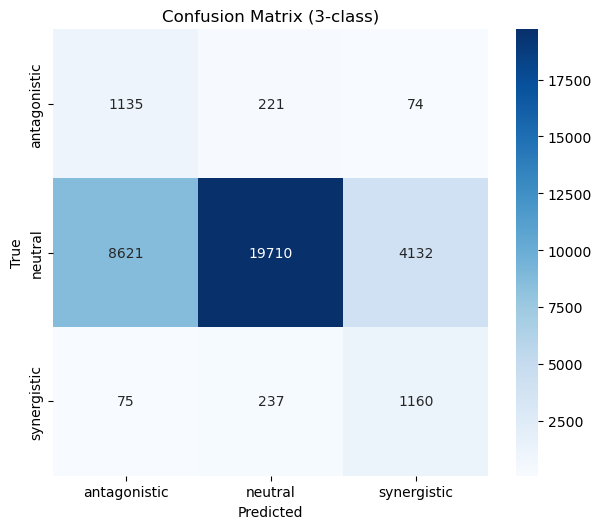

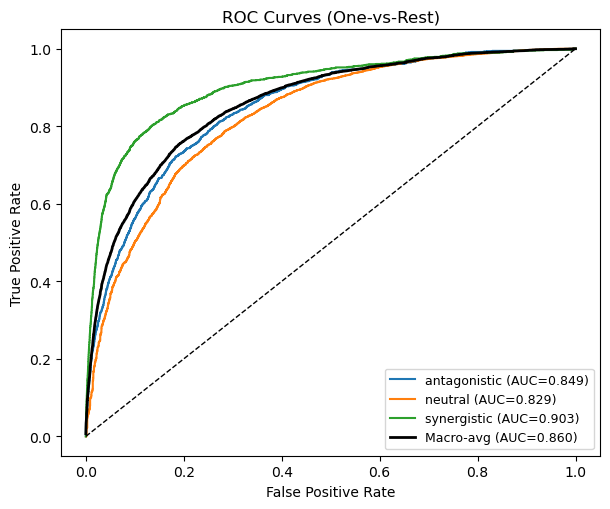

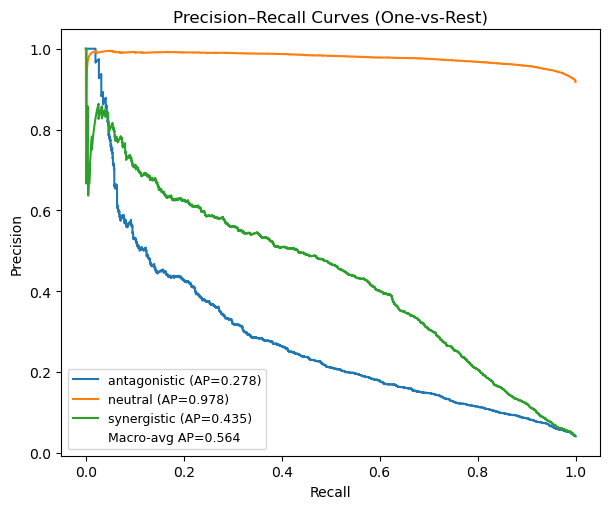

[OK] Saved confusion matrix → C:\Users\46762\VSCODE\BIG_PHARMA\data\processed\notebook_outputs\cm_multiclass.png


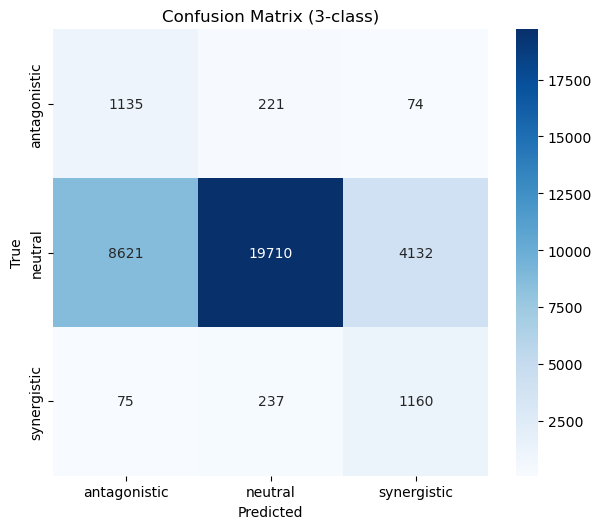

In [ ]:
# Uses already-trained `clf` and split `Xte`, `yte`. Works for both binary and 3-class setups.
# Comments in ENGLISH.

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Predict on test once (no retraining) ---
y_pred_scores = clf.predict(Xte, batch_size=4096)

if BINARY_TARGET:
    # Binary: scores are shape (N,1)
    y_score = y_pred_scores.ravel()
    y_pred  = (y_score >= 0.5).astype(int)

    # Report
    print("\n=== Classification Report (binary) ===")
    print(classification_report(yte, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(yte, y_pred)
    plt.figure(figsize=(5.3,4.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["non-synergy","synergy"],
                yticklabels=["non-synergy","synergy"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Confusion Matrix (Binary)")
    plt.tight_layout(); plt.show()

    # ROC curve + AUC
    fpr, tpr, _ = roc_curve(yte, y_score)
    roc_auc = auc(fpr, tpr)
    pr_prec, pr_rec, _ = precision_recall_curve(yte, y_score)
    pr_auc = average_precision_score(yte, y_score)

    plt.figure(figsize=(5.6,4.6))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Binary)"); plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.6,4.6))
    plt.plot(pr_rec, pr_prec, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Binary)"); plt.legend(loc="lower left")
    plt.tight_layout(); plt.show()

else:
    # Multiclass: scores are shape (N,3) with class order: antagonistic=0, neutral=1, synergistic=2
    class_names = ["antagonistic","neutral","synergistic"]
    y_proba = y_pred_scores  # (N,3)
    y_pred  = np.argmax(y_proba, axis=1)

    # Report
    print("\n=== Classification Report (3-class) ===")
    print(classification_report(yte, y_pred, digits=3, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(yte, y_pred)
    plt.figure(figsize=(6.2,5.4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Confusion Matrix (3-class)")
    plt.tight_layout(); plt.show()

    # One-vs-rest ROC & PR for each class + macro-average
    y_true_ovr = label_binarize(yte, classes=[0,1,2])  # shape (N,3)
    fpr, tpr, roc_auc = dict(), dict(), dict()
    prec, rec, pr_auc = dict(), dict(), dict()

    for i, cname in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_true_ovr[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        prec[i], rec[i], _ = precision_recall_curve(y_true_ovr[:, i], y_proba[:, i])
        pr_auc[i] = average_precision_score(y_true_ovr[:, i], y_proba[:, i])

    # Macro-average ROC
    # Stack all fpr points, interpolate TPRs, then average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 3.0
    roc_auc_macro = auc(all_fpr, mean_tpr)

    # Macro-average PR (average of APs is common & stable)
    pr_auc_macro = np.mean([pr_auc[i] for i in range(3)])

    # Plot ROC curves
    plt.figure(figsize=(6.2,5.2))
    for i, cname in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f"{cname} (AUC={roc_auc[i]:.3f})")
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.plot(all_fpr, mean_tpr, 'k-', lw=2, label=f"Macro-avg (AUC={roc_auc_macro:.3f})")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout(); plt.show()

    # Plot PR curves
    plt.figure(figsize=(6.2,5.2))
    for i, cname in enumerate(class_names):
        plt.plot(rec[i], prec[i], label=f"{cname} (AP={pr_auc[i]:.3f})")
    plt.plot([], [], ' ', label=f"Macro-avg AP={pr_auc_macro:.3f}")  # legend line
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curves (One-vs-Rest)")
    plt.legend(loc="lower left", fontsize=9)
    plt.tight_layout(); plt.show()

# (Optional) Save last confusion matrix to OUT_DIR
try:
    save_path = OUT_DIR / ("cm_binary.png" if BINARY_TARGET else "cm_multiclass.png")
    plt.figure(figsize=(1,1)); plt.close()  # ensure previous figure is closed
    plt.figure(figsize=(6,5) if BINARY_TARGET else (6.2,5.4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=(["non-synergy","synergy"] if BINARY_TARGET else class_names),
                yticklabels=(["non-synergy","synergy"] if BINARY_TARGET else class_names))
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Confusion Matrix" + (" (Binary)" if BINARY_TARGET else " (3-class)"))
    plt.tight_layout(); plt.savefig(save_path, dpi=160)
    print(f"[OK] Saved confusion matrix → {save_path}")
except Exception as e:
    print("[WARN] Could not save confusion matrix:", e)

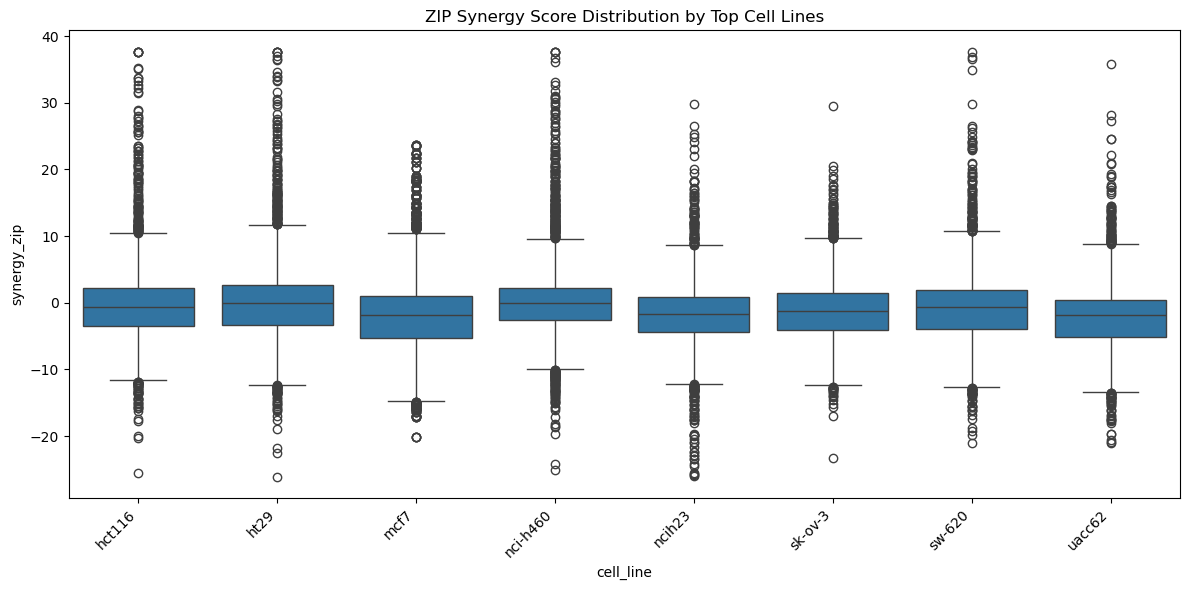

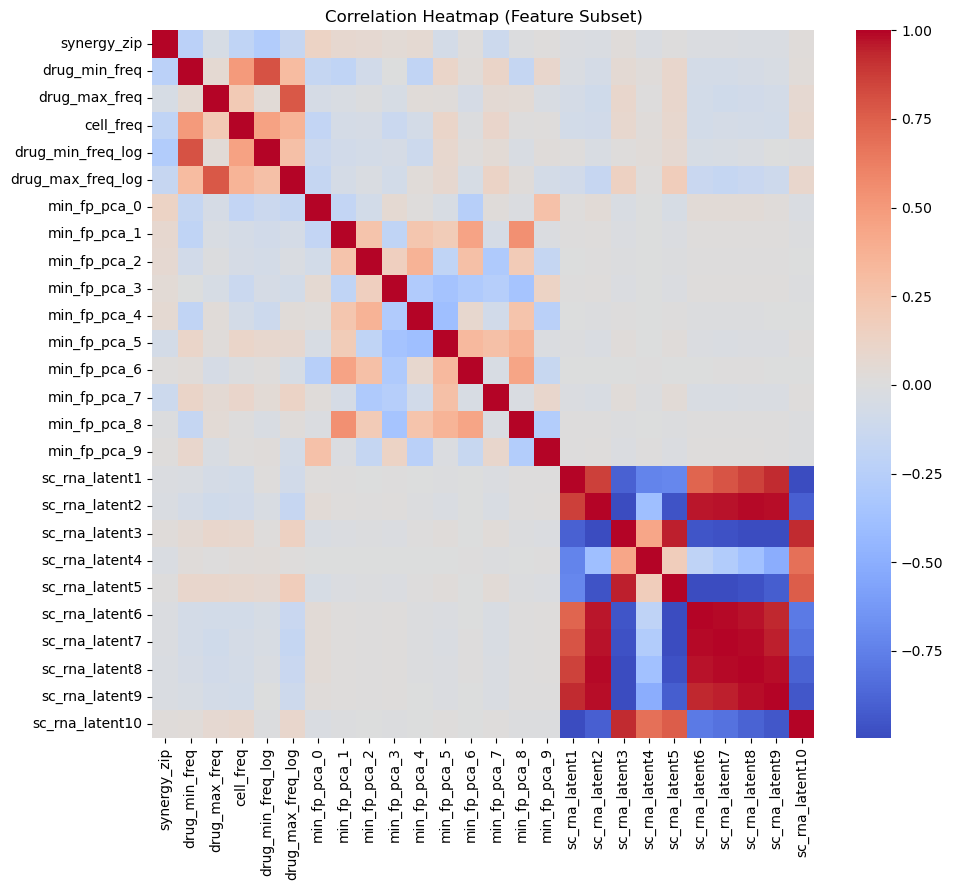

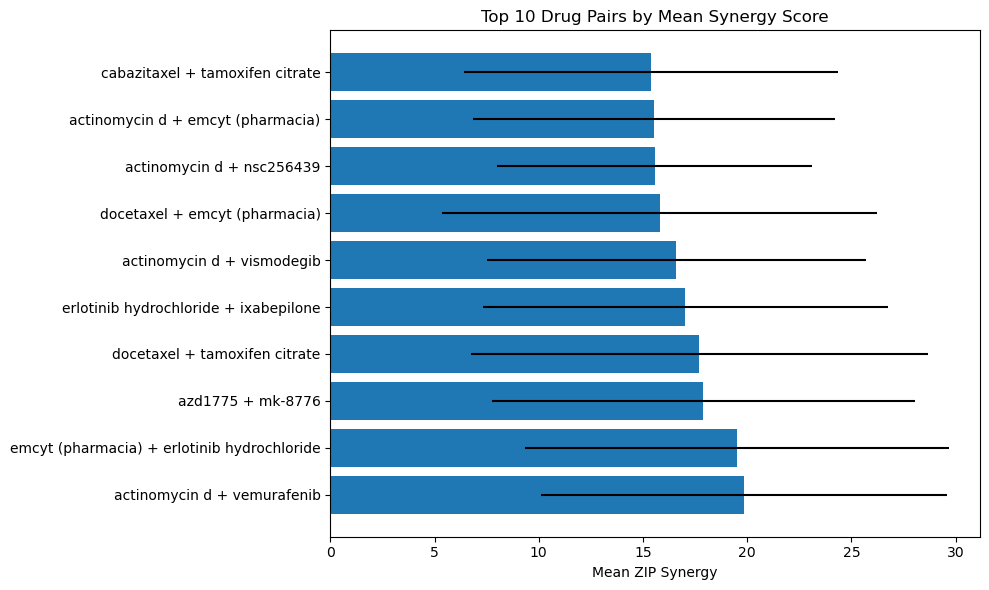

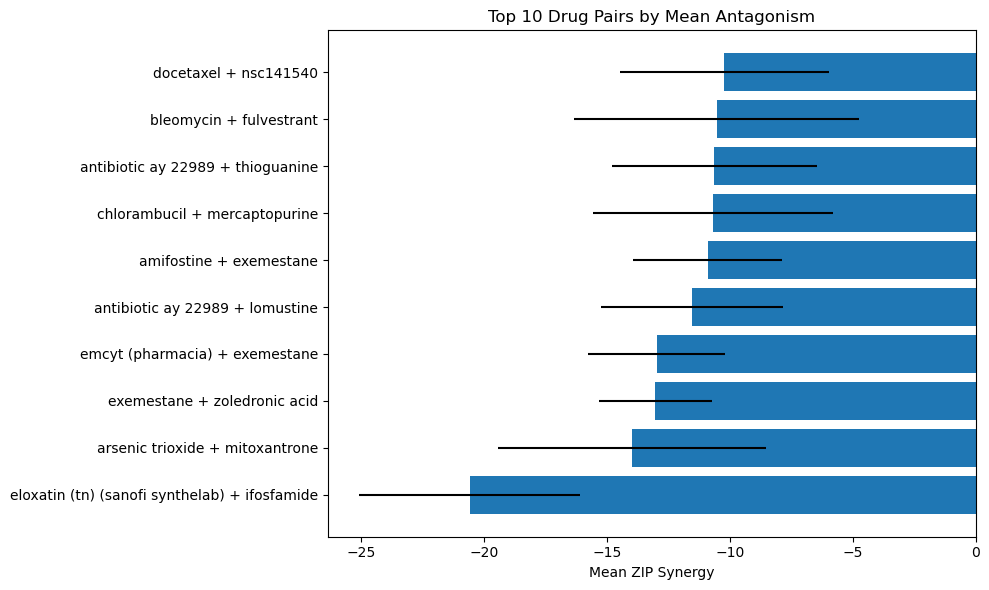

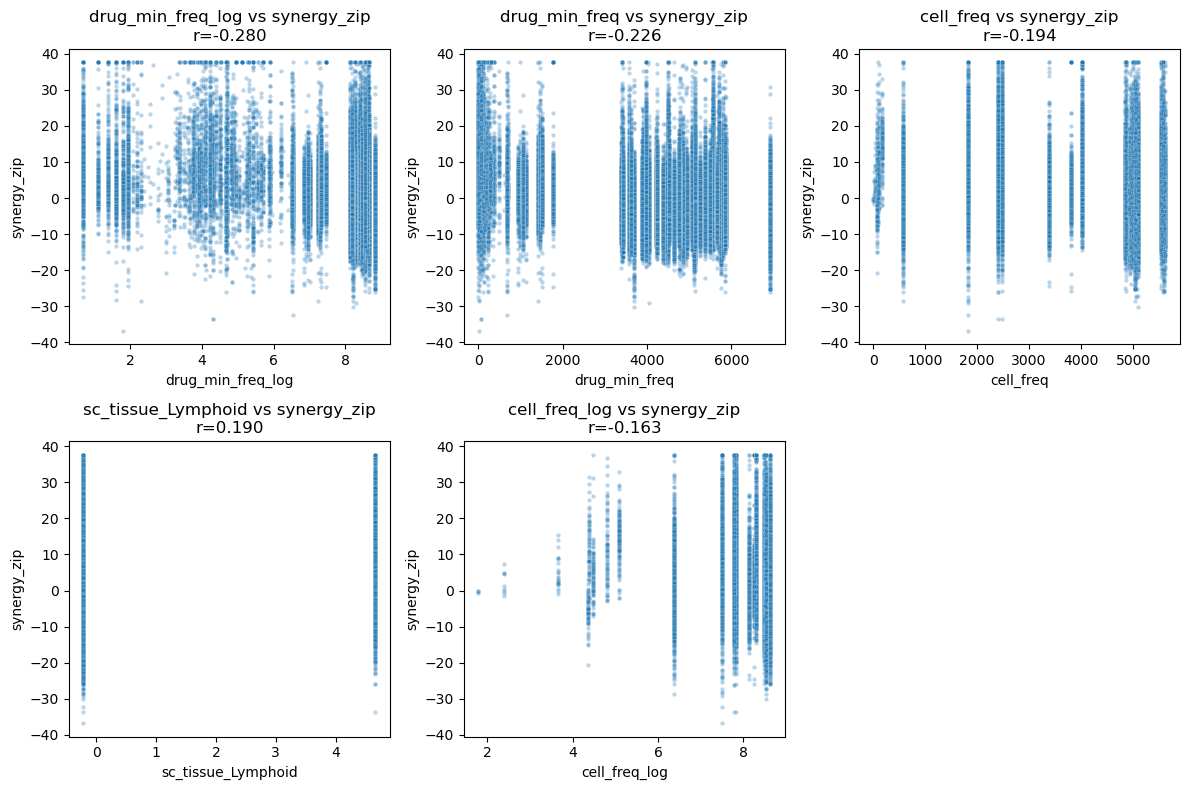

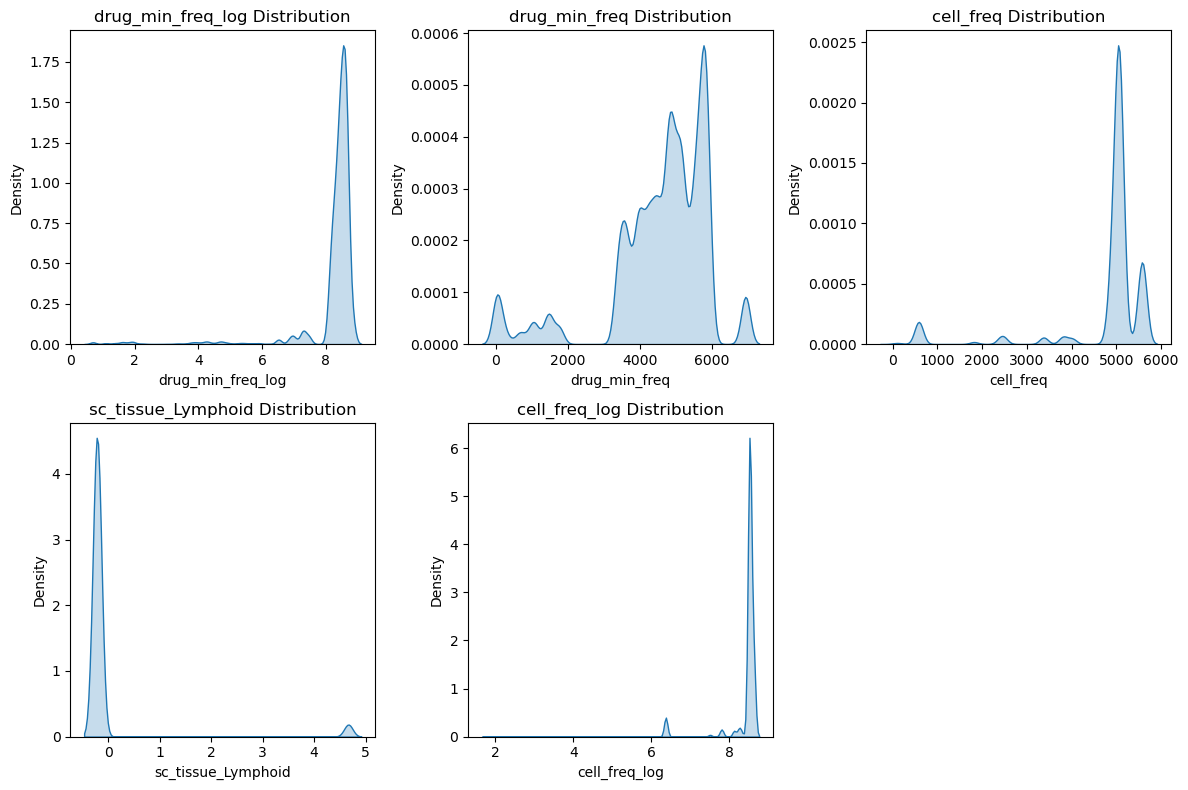

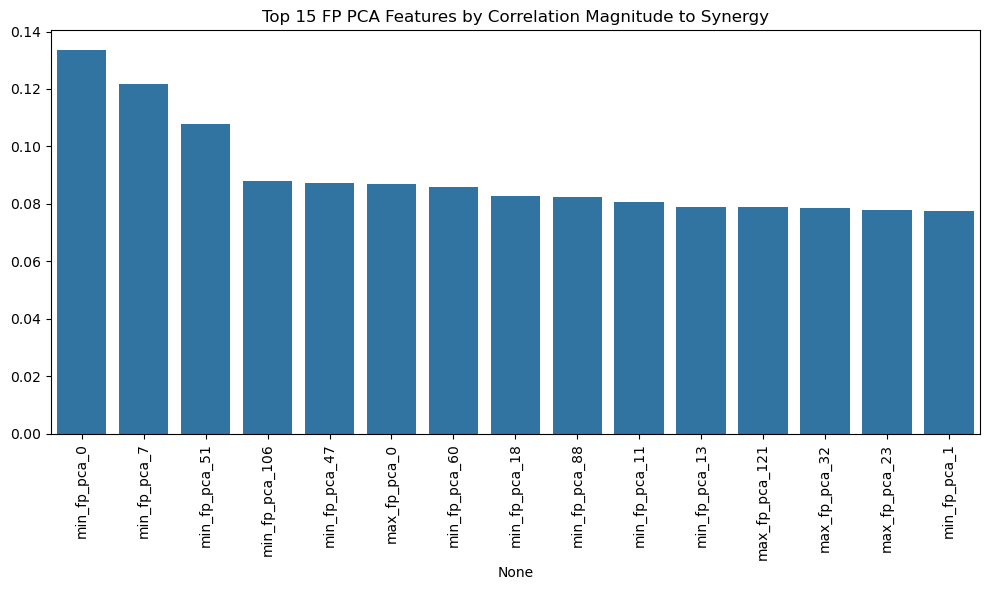

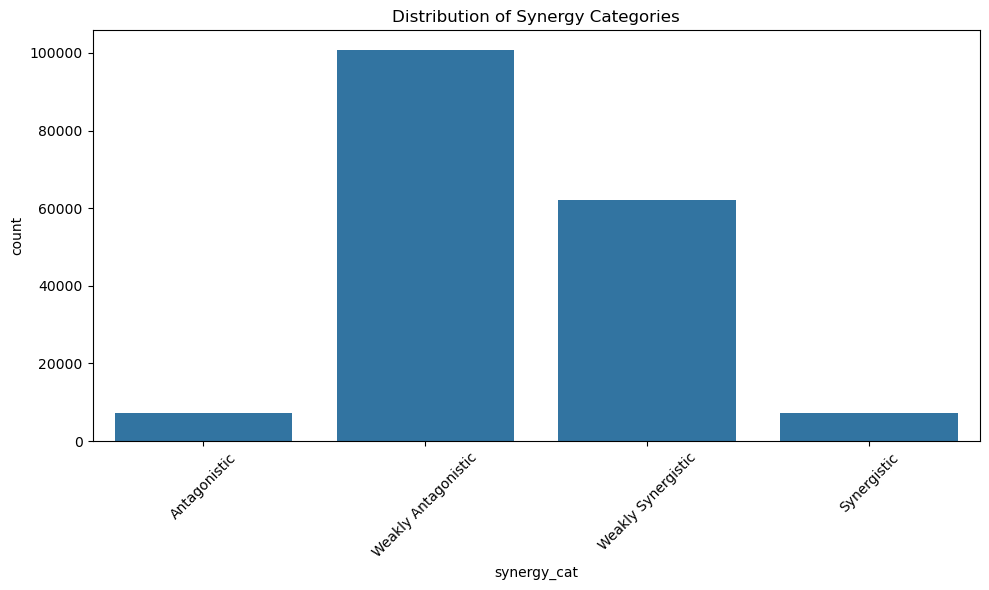

In [ ]:
# Distribution of synergy scores by cell line
if "cell_line" in df.columns:
    top_cells = df["cell_line"].value_counts().head(8).index.tolist()
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="cell_line", y="synergy_zip", data=df[df["cell_line"].isin(top_cells)])
    plt.title("ZIP Synergy Score Distribution by Top Cell Lines")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Correlation heatmap of numerical features (subset for clarity)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if len(numeric_cols) > 30:  # If too many columns, select a reasonable subset
    # Include synergy_zip and some representative columns from each feature type
    cols_to_plot = ["synergy_zip"] + \
                   [c for c in numeric_cols if "freq" in c][:5] + \
                   [c for c in numeric_cols if "fp_pca" in c][:10] + \
                   [c for c in numeric_cols if "rna_latent" in c][:10]
    corr_subset = df[cols_to_plot].corr()
    plt.figure(figsize=(10, 9))
    sns.heatmap(corr_subset, cmap="coolwarm", center=0, 
                xticklabels=True, yticklabels=True)
    plt.title("Correlation Heatmap (Feature Subset)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Top drug pairs by synergy score
if all(col in df.columns for col in ["drug_min", "drug_max", "synergy_zip"]):
    drug_pair_synergy = df.groupby(["drug_min", "drug_max"])["synergy_zip"].agg(
        ['mean', 'std', 'count']).reset_index()
    drug_pair_synergy = drug_pair_synergy[drug_pair_synergy['count'] >= 5]  # At least 5 observations
    
    # Top synergistic pairs
    top_synergy = drug_pair_synergy.sort_values('mean', ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(top_synergy['drug_min'] + ' + ' + top_synergy['drug_max'], 
             top_synergy['mean'], xerr=top_synergy['std'])
    plt.title("Top 10 Drug Pairs by Mean Synergy Score")
    plt.xlabel("Mean ZIP Synergy")
    plt.tight_layout()
    plt.show()
    
    # Top antagonistic pairs
    top_antagonistic = drug_pair_synergy.sort_values('mean').head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(top_antagonistic['drug_min'] + ' + ' + top_antagonistic['drug_max'], 
             top_antagonistic['mean'], xerr=top_antagonistic['std'])
    plt.title("Top 10 Drug Pairs by Mean Antagonism")
    plt.xlabel("Mean ZIP Synergy")
    plt.tight_layout()
    plt.show()

# Feature density plots for top correlated features with synergy_zip
if "synergy_zip" in df.columns:
    corr_to_target = df.corr(numeric_only=True)["synergy_zip"].abs().sort_values(ascending=False)
    top_corr_feats = corr_to_target.index[1:6]  # Skip synergy_zip itself
    
    plt.figure(figsize=(12, 8))
    for i, feat in enumerate(top_corr_feats):
        plt.subplot(2, 3, i+1)
        sns.scatterplot(x=df[feat], y=df["synergy_zip"], alpha=0.3, s=10)
        plt.title(f"{feat} vs synergy_zip\nr={df[feat].corr(df['synergy_zip']):.3f}")
    plt.tight_layout()
    plt.show()
    
    # KDE plots to show density distributions
    plt.figure(figsize=(12, 8))
    for i, feat in enumerate(top_corr_feats):
        plt.subplot(2, 3, i+1)
        sns.kdeplot(df[feat], fill=True)
        plt.title(f"{feat} Distribution")
    plt.tight_layout()
    plt.show()

# PCA feature importance visualization
if len(fp_cols) > 0:
    fp_corr = pd.Series([df[col].corr(df["synergy_zip"]) for col in fp_cols], index=fp_cols)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fp_corr.abs().sort_values(ascending=False).head(15).index, 
                y=fp_corr.abs().sort_values(ascending=False).head(15).values)
    plt.title("Top 15 FP PCA Features by Correlation Magnitude to Synergy")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# ZIP synergy score ranges - categorical visualization
df["synergy_cat"] = pd.cut(df["synergy_zip"], 
                           bins=[-float('inf'), NEG_CUTOFF, 0, POS_CUTOFF, float('inf')],
                           labels=["Antagonistic", "Weakly Antagonistic", "Weakly Synergistic", "Synergistic"])
plt.figure(figsize=(10, 6))
sns.countplot(x="synergy_cat", data=df)
plt.title("Distribution of Synergy Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# IMPORTANT: We create labels from synergy_zip. To avoid trivial leakage, we EXCLUDE synergy_zip as a model input.

BINARY_TARGET = False   # True: synergy vs rest; False: 3-class

df_cls = df.copy()
def zip_to_class(x):
    if pd.isna(x): return np.nan
    if x > POS_CUTOFF:   return "synergistic"
    elif x < NEG_CUTOFF: return "antagonistic"
    else:                return "neutral"

df_cls["synergy_class"] = df_cls["synergy_zip"].map(zip_to_class)
df_cls = df_cls.dropna(subset=["synergy_class"]).reset_index(drop=True)

# Build continuous feature blocks (no ZIP)
min_fp_cols = [c for c in df_cls.columns if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in df_cls.columns if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in df_cls.columns if c.startswith("sc_rna_latent")]
tissue_cols = [c for c in df_cls.columns if c.startswith("sc_tissue_")]
freq_cols   = [c for c in df_cls.columns if ("freq" in c and not c.startswith("min_fp_pca_") and not c.startswith("max_fp_pca_") and not c.startswith("sc_rna_latent"))]

# Input dict for Keras Functional API
X_all = {}
X_all["min_fp"] = df_cls[min_fp_cols].astype("float32").fillna(0).to_numpy()
X_all["max_fp"] = df_cls[max_fp_cols].astype("float32").fillna(0).to_numpy()
X_all["fp_hadamard"] = (X_all["min_fp"] * X_all["max_fp"]).astype("float32")
X_all["fp_absdiff"]  = np.abs(X_all["min_fp"] - X_all["max_fp"]).astype("float32")
if len(rna_cols):    X_all["rna"]    = df_cls[rna_cols].astype("float32").fillna(0).to_numpy()
if len(tissue_cols): X_all["tissue"] = df_cls[tissue_cols].astype("float32").fillna(0).to_numpy()
if len(freq_cols):   X_all["freq"]   = df_cls[freq_cols].astype("float32").fillna(0).to_numpy()

# Target
if BINARY_TARGET:
    y_all = df_cls["synergy_class"].map(lambda z: 1 if z=="synergistic" else 0).astype("int32").to_numpy()
else:
    mapping = {"antagonistic":0, "neutral":1, "synergistic":2}
    y_all = df_cls["synergy_class"].map(mapping).astype("int32").to_numpy()

# Groups to avoid leakage across identical (drug_min, drug_max, cell_line)
if {"drug_min","drug_max","cell_line"}.issubset(df_cls.columns):
    groups = (df_cls["drug_min"].astype(str) + "|" + df_cls["drug_max"].astype(str) + "|" + df_cls["cell_line"].astype(str))
else:
    groups = pd.Series(np.arange(len(df_cls)), dtype=str)

# Group-aware split
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
idx = np.arange(len(df_cls))
tr_idx, te_idx = next(gss.split(idx, y_all, groups=groups))

def split_dict(Xd):
    return {k: v[tr_idx] for k,v in Xd.items()}, {k: v[te_idx] for k,v in Xd.items()}
Xtr, Xte = split_dict(X_all)
ytr, yte = y_all[tr_idx], y_all[te_idx]

# Standardize continuous blocks (recommended for DL)
from sklearn.preprocessing import StandardScaler
scalers = {}
for name in ["min_fp","max_fp","fp_hadamard","fp_absdiff","rna","tissue","freq"]:
    if name in Xtr:
        sc = StandardScaler(with_mean=True, with_std=True)
        Xtr[name] = sc.fit_transform(Xtr[name])
        Xte[name] = sc.transform(Xte[name])
        scalers[name] = sc

# Build classifier model (multimodal towers)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
import numpy as np

inputs = []
towers = []

def tower(name, x, units=[256,128], drop=0.25):
    # Simple MLP block used per modality
    for i, u in enumerate(units):
        x = layers.Dense(u, activation="relu", name=f"{name}_d{i}")(x)
        x = layers.Dropout(drop, name=f"{name}_do{i}")(x)
    return x

for name in ["min_fp","max_fp","fp_hadamard","fp_absdiff","rna","tissue","freq"]:
    if name in Xtr:
        inp = keras.Input(shape=(Xtr[name].shape[1],), dtype="float32", name=name)
        inputs.append(inp)
        towers.append(tower(name, inp, units=[256,128], drop=0.25))

fused = layers.Concatenate(name="fuse")(towers) if len(towers)>1 else towers[0]
x = fused
for i,u in enumerate([512,256,128]):
    x = layers.Dense(u, activation="relu", name=f"trunk_d{i}")(x)
    x = layers.Dropout(0.25, name=f"trunk_do{i}")(x)

# Output head (no compile yet — we swap in focal loss below)
if BINARY_TARGET:
    out = layers.Dense(1, activation="sigmoid", name="cls")(x)
    clf = keras.Model(inputs, out, name="DL_bin_classifier")
else:
    out = layers.Dense(3, activation="softmax", name="cls")(x)
    clf = keras.Model(inputs, out, name="DL_3class_classifier")

# =========================
# (1) Class-balanced weights (effective number) + (2) Focal loss with per-class alpha
# =========================
from tensorflow.keras import backend as K

def class_balanced_weights(y, beta=0.999):
    """Return dict {class_id: weight} using Cui et al. (effective number of samples)."""
    classes, counts = np.unique(y, return_counts=True)
    effective_num = (1.0 - np.power(beta, counts)) / (1.0 - beta)
    weights = (np.sum(effective_num) / (len(classes) * effective_num))
    return {int(c): float(w) for c, w in zip(classes, weights)}

cb_weights = class_balanced_weights(ytr, beta=0.999)

if BINARY_TARGET:
    # Binary focal loss (positive=1, negative=0)
    alpha_pos = cb_weights.get(1, 1.0)
    alpha_neg = cb_weights.get(0, 1.0)
    gamma = 2.0

    def binary_focal_loss(alpha_pos=alpha_pos, alpha_neg=alpha_neg, gamma=gamma):
        def loss(y_true, y_pred):
            y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)                 # (N,)
            y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())     # (N,1)
            p1 = tf.reshape(y_pred, [-1])                                         # P(y=1)
            p0 = 1. - p1
            p_t = y_true * p1 + (1. - y_true) * p0
            alpha_t = y_true * alpha_pos + (1. - y_true) * alpha_neg
            return tf.reduce_mean(-alpha_t * tf.pow(1. - p_t, gamma) * tf.math.log(p_t))
        return loss

    clf.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss=binary_focal_loss(), metrics=["accuracy"])
else:
    # Multiclass focal loss: damp neutral a bit to reduce dominance
    neutral_damp = 0.7  # 0.5–0.9; lower → weaker neutral
    alpha_vec = tf.constant([
        cb_weights.get(0, 1.0),                 # antagonistic
        cb_weights.get(1, 1.0) * neutral_damp,  # neutral (down-weighted)
        cb_weights.get(2, 1.0)                  # synergistic
    ], dtype=tf.float32)
    gamma = 2.0

    def sparse_categorical_focal_loss(alpha=alpha_vec, gamma=gamma):
        def loss(y_true, y_pred):
            y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)                  # (N,)
            y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())     # (N,C)
            y_true_oh = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])            # (N,C)
            p_t = tf.reduce_sum(y_true_oh * y_pred, axis=-1)                      # (N,)
            alpha_t = tf.reduce_sum(y_true_oh * alpha, axis=-1)                   # (N,)
            return tf.reduce_mean(-alpha_t * tf.pow(1. - p_t, gamma) * tf.math.log(p_t))
        return loss

    clf.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss=sparse_categorical_focal_loss(), metrics=["accuracy"])

# Callbacks (unchanged)
cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
]

# Train (NOTE: no class_weight passed; focal α already balances classes)
hist = clf.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=60,
    batch_size=1024,
    callbacks=cb,
    verbose=2
)

# =========================
# Evaluation (same as before)
# =========================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

if BINARY_TARGET:
    y_prob = clf.predict(Xte, batch_size=4096).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    print("\n=== Classification Report (binary) ===")
    print(classification_report(yte, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))
    try:
        print(f"ROC-AUC: {roc_auc_score(yte, y_prob):.3f} | PR-AUC: {average_precision_score(yte, y_prob):.3f}")
    except Exception:
        pass
else:
    y_proba = clf.predict(Xte, batch_size=4096)
    y_pred = np.argmax(y_proba, axis=1)
    print("\n=== Classification Report (3-class) ===")
    print(classification_report(yte, y_pred, digits=3, target_names=["antagonistic","neutral","synergistic"]))
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))
    # Synergy-vs-rest AUCs (optional)
    try:
        pos_idx = 2  # synergistic
        y_bin = (yte == pos_idx).astype(int)
        print(f"Synergy ROC-AUC: {roc_auc_score(y_bin, y_proba[:,pos_idx]):.3f} | PR-AUC: {average_precision_score(y_bin, y_proba[:,pos_idx]):.3f}")
    except Exception:
        pass

# Save models (optional)
clf_path = OUT_DIR / ("dl_classifier_binary.keras" if BINARY_TARGET else "dl_classifier_3class.keras")
clf.save(clf_path); print(f"[OK] Saved classifier → {clf_path}")
reg_path = OUT_DIR / "dl_regressor.keras"
reg_model.save(reg_path); print(f"[OK] Saved regressor → {reg_path}")

Epoch 1/60
139/139 - 4s - loss: 0.1151 - accuracy: 0.9110 - val_loss: 0.0993 - val_accuracy: 0.9151 - lr: 0.0010 - 4s/epoch - 26ms/step
Epoch 2/60
139/139 - 2s - loss: 0.0912 - accuracy: 0.9170 - val_loss: 0.0920 - val_accuracy: 0.9142 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 3/60
139/139 - 2s - loss: 0.0851 - accuracy: 0.9179 - val_loss: 0.0883 - val_accuracy: 0.9193 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 4/60
139/139 - 2s - loss: 0.0812 - accuracy: 0.9191 - val_loss: 0.0861 - val_accuracy: 0.9207 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 5/60
139/139 - 2s - loss: 0.0784 - accuracy: 0.9196 - val_loss: 0.0860 - val_accuracy: 0.9198 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 6/60
139/139 - 2s - loss: 0.0750 - accuracy: 0.9202 - val_loss: 0.0806 - val_accuracy: 0.9178 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 7/60
139/139 - 2s - loss: 0.0733 - accuracy: 0.9205 - val_loss: 0.0825 - val_accuracy: 0.9170 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 8/60
139/139 - 2s - loss: 0.0705 - accurac

In [ ]:
# IMPORTANT: We create labels from synergy_zip. To avoid trivial leakage, we EXCLUDE synergy_zip as a model input.

BINARY_TARGET = False   # True: synergy vs rest; False: 3-class

df_cls = df.copy()
def zip_to_class(x):
    if pd.isna(x): return np.nan
    if x > POS_CUTOFF:   return "synergistic"
    elif x < NEG_CUTOFF: return "antagonistic"
    else:                return "neutral"

df_cls["synergy_class"] = df_cls["synergy_zip"].map(zip_to_class)
df_cls = df_cls.dropna(subset=["synergy_class"]).reset_index(drop=True)

# Build continuous feature blocks (no ZIP)
min_fp_cols = [c for c in df_cls.columns if c.startswith("min_fp_pca_")]
max_fp_cols = [c for c in df_cls.columns if c.startswith("max_fp_pca_")]
rna_cols    = [c for c in df_cls.columns if c.startswith("sc_rna_latent")]
tissue_cols = [c for c in df_cls.columns if c.startswith("sc_tissue_")]
freq_cols   = [c for c in df_cls.columns if ("freq" in c and not c.startswith("min_fp_pca_") and not c.startswith("max_fp_pca_") and not c.startswith("sc_rna_latent"))]

# Input dict for Keras Functional API
X_all = {}
X_all["min_fp"] = df_cls[min_fp_cols].astype("float32").fillna(0).to_numpy()
X_all["max_fp"] = df_cls[max_fp_cols].astype("float32").fillna(0).to_numpy()
X_all["fp_hadamard"] = (X_all["min_fp"] * X_all["max_fp"]).astype("float32")
X_all["fp_absdiff"]  = np.abs(X_all["min_fp"] - X_all["max_fp"]).astype("float32")
if len(rna_cols):    X_all["rna"]    = df_cls[rna_cols].astype("float32").fillna(0).to_numpy()
if len(tissue_cols): X_all["tissue"] = df_cls[tissue_cols].astype("float32").fillna(0).to_numpy()
if len(freq_cols):   X_all["freq"]   = df_cls[freq_cols].astype("float32").fillna(0).to_numpy()

# Target
if BINARY_TARGET:
    y_all = df_cls["synergy_class"].map(lambda z: 1 if z=="synergistic" else 0).astype("int32").to_numpy()
else:
    mapping = {"antagonistic":0, "neutral":1, "synergistic":2}
    y_all = df_cls["synergy_class"].map(mapping).astype("int32").to_numpy()

# Groups to avoid leakage across identical (drug_min, drug_max, cell_line)
if {"drug_min","drug_max","cell_line"}.issubset(df_cls.columns):
    groups = (df_cls["drug_min"].astype(str) + "|" + df_cls["drug_max"].astype(str) + "|" + df_cls["cell_line"].astype(str))
else:
    groups = pd.Series(np.arange(len(df_cls)), dtype=str)

# Group-aware split
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
idx = np.arange(len(df_cls))
tr_idx, te_idx = next(gss.split(idx, y_all, groups=groups))

def split_dict(Xd):
    return {k: v[tr_idx] for k,v in Xd.items()}, {k: v[te_idx] for k,v in Xd.items()}
Xtr, Xte = split_dict(X_all)
ytr, yte = y_all[tr_idx], y_all[te_idx]

# Standardize continuous blocks (recommended for DL)
from sklearn.preprocessing import StandardScaler
scalers = {}
for name in ["min_fp","max_fp","fp_hadamard","fp_absdiff","rna","tissue","freq"]:
    if name in Xtr:
        sc = StandardScaler(with_mean=True, with_std=True)
        Xtr[name] = sc.fit_transform(Xtr[name])
        Xte[name] = sc.transform(Xte[name])
        scalers[name] = sc

# Build classifier model (multimodal towers)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
import numpy as np

inputs = []
towers = []

def tower(name, x, units=[256,128], drop=0.25):
    # Simple MLP block used per modality
    for i, u in enumerate(units):
        x = layers.Dense(u, activation="relu", name=f"{name}_d{i}")(x)
        x = layers.Dropout(drop, name=f"{name}_do{i}")(x)
    return x

for name in ["min_fp","max_fp","fp_hadamard","fp_absdiff","rna","tissue","freq"]:
    if name in Xtr:
        inp = keras.Input(shape=(Xtr[name].shape[1],), dtype="float32", name=name)
        inputs.append(inp)
        towers.append(tower(name, inp, units=[256,128], drop=0.25))

fused = layers.Concatenate(name="fuse")(towers) if len(towers)>1 else towers[0]
x = fused
for i,u in enumerate([512,256,128]):
    x = layers.Dense(u, activation="relu", name=f"trunk_d{i}")(x)
    x = layers.Dropout(0.25, name=f"trunk_do{i}")(x)

# Output head (no compile yet — we swap in focal loss below)
if BINARY_TARGET:
    out = layers.Dense(1, activation="sigmoid", name="cls")(x)
    clf = keras.Model(inputs, out, name="DL_bin_classifier")
else:
    out = layers.Dense(3, activation="softmax", name="cls")(x)
    clf = keras.Model(inputs, out, name="DL_3class_classifier")

# =========================
# (1) Class-balanced weights (effective number) + (2) Focal loss with per-class alpha
# =========================
from tensorflow.keras import backend as K

def class_balanced_weights(y, beta=0.999):
    """Return dict {class_id: weight} using Cui et al. (effective number of samples)."""
    classes, counts = np.unique(y, return_counts=True)
    effective_num = (1.0 - np.power(beta, counts)) / (1.0 - beta)
    weights = (np.sum(effective_num) / (len(classes) * effective_num))
    return {int(c): float(w) for c, w in zip(classes, weights)}

cb_weights = class_balanced_weights(ytr, beta=0.999)

if BINARY_TARGET:
    # Binary focal loss (positive=1, negative=0)
    alpha_pos = cb_weights.get(1, 1.0)
    alpha_neg = cb_weights.get(0, 1.0)
    gamma = 2.0

    def binary_focal_loss(alpha_pos=alpha_pos, alpha_neg=alpha_neg, gamma=gamma):
        def loss(y_true, y_pred):
            y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)                 # (N,)
            y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())     # (N,1)
            p1 = tf.reshape(y_pred, [-1])                                         # P(y=1)
            p0 = 1. - p1
            p_t = y_true * p1 + (1. - y_true) * p0
            alpha_t = y_true * alpha_pos + (1. - y_true) * alpha_neg
            return tf.reduce_mean(-alpha_t * tf.pow(1. - p_t, gamma) * tf.math.log(p_t))
        return loss

    clf.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss=binary_focal_loss(), metrics=["accuracy"])
else:
    # Multiclass focal loss: damp neutral a bit to reduce dominance
    neutral_damp = 0.5  # 0.5–0.9; lower → weaker neutral
    alpha_vec = tf.constant([
        cb_weights.get(0, 1.0),                 # antagonistic
        cb_weights.get(1, 1.0) * neutral_damp,  # neutral (down-weighted)
        cb_weights.get(2, 1.0)                  # synergistic
    ], dtype=tf.float32)
    gamma = 2.5

    def sparse_categorical_focal_loss(alpha=alpha_vec, gamma=gamma):
        def loss(y_true, y_pred):
            y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)                  # (N,)
            y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())     # (N,C)
            y_true_oh = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])            # (N,C)
            p_t = tf.reduce_sum(y_true_oh * y_pred, axis=-1)                      # (N,)
            alpha_t = tf.reduce_sum(y_true_oh * alpha, axis=-1)                   # (N,)
            return tf.reduce_mean(-alpha_t * tf.pow(1. - p_t, gamma) * tf.math.log(p_t))
        return loss

    clf.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss=sparse_categorical_focal_loss(), metrics=["accuracy"])

# Callbacks (unchanged)
cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
]

# Train (NOTE: no class_weight passed; focal α already balances classes)
hist = clf.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=60,
    batch_size=1024,
    callbacks=cb,
    verbose=2
)

# =========================
# Evaluation (same as before)
# =========================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

if BINARY_TARGET:
    y_prob = clf.predict(Xte, batch_size=4096).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    print("\n=== Classification Report (binary) ===")
    print(classification_report(yte, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))
    try:
        print(f"ROC-AUC: {roc_auc_score(yte, y_prob):.3f} | PR-AUC: {average_precision_score(yte, y_prob):.3f}")
    except Exception:
        pass
else:
    y_proba = clf.predict(Xte, batch_size=4096)
    y_pred = np.argmax(y_proba, axis=1)
    print("\n=== Classification Report (3-class) ===")
    print(classification_report(yte, y_pred, digits=3, target_names=["antagonistic","neutral","synergistic"]))
    print("Confusion matrix:\n", confusion_matrix(yte, y_pred))
    # Synergy-vs-rest AUCs (optional)
    try:
        pos_idx = 2  # synergistic
        y_bin = (yte == pos_idx).astype(int)
        print(f"Synergy ROC-AUC: {roc_auc_score(y_bin, y_proba[:,pos_idx]):.3f} | PR-AUC: {average_precision_score(y_bin, y_proba[:,pos_idx]):.3f}")
    except Exception:
        pass

# Save models (optional)
clf_path = OUT_DIR / ("dl_classifier_binary.keras" if BINARY_TARGET else "dl_classifier_3class.keras")
clf.save(clf_path); print(f"[OK] Saved classifier → {clf_path}")
reg_path = OUT_DIR / "dl_regressor.keras"
reg_model.save(reg_path); print(f"[OK] Saved regressor → {reg_path}")

Epoch 1/60
139/139 - 4s - loss: 0.0881 - accuracy: 0.9072 - val_loss: 0.0735 - val_accuracy: 0.9032 - lr: 0.0010 - 4s/epoch - 25ms/step
Epoch 2/60
139/139 - 2s - loss: 0.0665 - accuracy: 0.9140 - val_loss: 0.0675 - val_accuracy: 0.9172 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 3/60
139/139 - 2s - loss: 0.0620 - accuracy: 0.9149 - val_loss: 0.0663 - val_accuracy: 0.9147 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 4/60
139/139 - 2s - loss: 0.0588 - accuracy: 0.9152 - val_loss: 0.0622 - val_accuracy: 0.9185 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 5/60
139/139 - 2s - loss: 0.0561 - accuracy: 0.9149 - val_loss: 0.0599 - val_accuracy: 0.9161 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 6/60
139/139 - 2s - loss: 0.0539 - accuracy: 0.9154 - val_loss: 0.0600 - val_accuracy: 0.9158 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 7/60
139/139 - 2s - loss: 0.0513 - accuracy: 0.9157 - val_loss: 0.0585 - val_accuracy: 0.9193 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 8/60
139/139 - 2s - loss: 0.0503 - accurac

[INFO] Ensemble with base models: ['HistGBR', 'RandomForest', 'DL']
[BASE::HistGBR] Val MAE=3.269 | RMSE=4.642 | R2=0.412 | r=0.644
[BASE::RandomForest] Val MAE=3.050 | RMSE=4.435 | R2=0.463 | r=0.682
[BASE::DL] Val MAE=3.054 | RMSE=4.399 | R2=0.472 | r=0.698
[Ensemble::SimpleAverage] Val MAE=2.941 | RMSE=4.244 | R2=0.508 | r=0.716
[Ensemble::ConvexBlend(HistGBR=0.00,RandomForest=0.50,DL=0.50)] Val MAE=2.884 | RMSE=4.189 | R2=0.521 | r=0.722
[INFO] Optimal convex weights: {'HistGBR': 0.0, 'RandomForest': 0.5, 'DL': 0.5}
[Ensemble::Stacking(Ridge α=1.0)] Val MAE=2.884 | RMSE=4.185 | R2=0.522 | r=0.722
[INFO] Stacking coefficients: {'HistGBR': 0.05945760564992898, 'RandomForest': 0.4745357763207655, 'DL': 0.5120973814851979}, intercept=0.0701


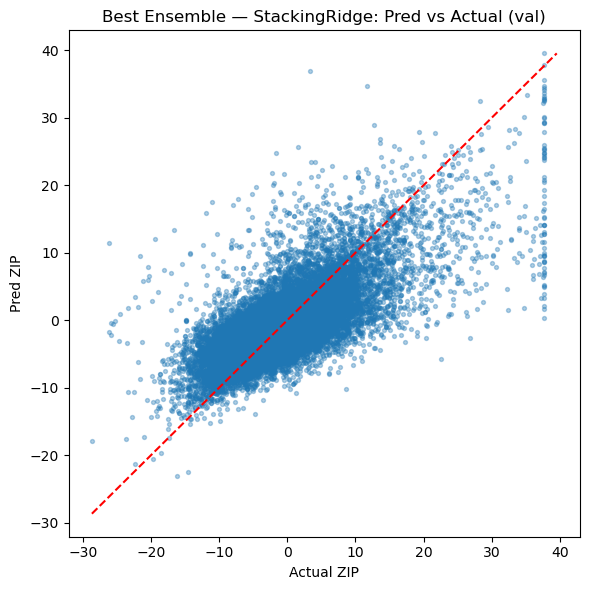

In [ ]:
# This cell combines HistGBR, RandomForest, and DL predictions into an ensemble.
# It reports metrics for:
#   - Simple average
#   - RMSE-minimizing convex blend (grid search over weights)
#   - Linear meta-learner (stacking via Ridge)
# Works even if DL is missing (falls back to classical models only).

from sklearn.linear_model import Ridge, LinearRegression

def eval_reg(y_true, y_hat, name="model"):
    mae  = mean_absolute_error(y_true, y_hat)
    rmse = float(np.sqrt(np.mean((y_true - y_hat)**2)))
    r2   = r2_score(y_true, y_hat)
    r    = float(np.corrcoef(y_true, y_hat)[0,1]) if len(y_true) > 1 else np.nan
    print(f"[{name}] Val MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | r={r:.3f}")
    return dict(name=name, MAE=mae, RMSE=rmse, R2=r2, r=r)

# Collect available prediction vectors
preds = []
names = []
if 'pred_val' in globals():
    preds.append(pred_val.reshape(-1))
    names.append('HistGBR')
if 'pred_val_rf' in globals():
    preds.append(pred_val_rf.reshape(-1))
    names.append('RandomForest')
if 'pred_va' in globals():
    try:
        preds.append(pred_va.reshape(-1))
        names.append('DL')
    except Exception:
        pass

assert len(preds) >= 2, "Need at least two base predictors to ensemble."

P = np.vstack(preds).T  # shape: (n_samples, n_models)
print(f"[INFO] Ensemble with base models: {names}")

# --- Baselines: each model alone
for i, nm in enumerate(names):
    _ = eval_reg(y_val, P[:, i], name=f"BASE::{nm}")

# --- Simple average
avg_pred = np.mean(P, axis=1)
_ = eval_reg(y_val, avg_pred, name="Ensemble::SimpleAverage")

# --- Convex blend (weights >=0, sum=1) via coarse grid search
def convex_blend(P, y, step=0.05):
    m = P.shape[1]
    if m == 2:
        # Only two models: w in [0,1]
        grid = np.arange(0.0, 1.0 + 1e-9, step)
        best = (None, np.inf)
        for w in grid:
            wv = np.array([w, 1-w], dtype=np.float64)
            yhat = P @ wv
            rmse = float(np.sqrt(np.mean((y - yhat)**2)))
            if rmse < best[1]:
                best = (wv, rmse)
        return best[0]
    else:
        # Three models: loop w1,w2, derive w3=1-w1-w2
        grid = np.arange(0.0, 1.0 + 1e-9, step)
        best = (None, np.inf)
        for w1 in grid:
            for w2 in grid:
                w3 = 1.0 - w1 - w2
                if w3 < 0.0: 
                    continue
                wv = np.array([w1, w2, w3], dtype=np.float64)
                yhat = P @ wv
                rmse = float(np.sqrt(np.mean((y - yhat)**2)))
                if rmse < best[1]:
                    best = (wv, rmse)
        return best[0]

w_opt = convex_blend(P, y_val, step=0.05)
y_blend = P @ w_opt
lbl = "Ensemble::ConvexBlend(" + ",".join(f"{n}={w:.2f}" for n, w in zip(names, w_opt)) + ")"
_ = eval_reg(y_val, y_blend, name=lbl)
print(f"[INFO] Optimal convex weights: {dict(zip(names, w_opt))}")

# --- Stacking with a linear meta-learner (Ridge)
# Note: we fit the meta-learner on the validation predictions (simple stacking without CV).
# For a more rigorous setup, generate out-of-fold predictions for submodels, then fit meta on OOF.
alpha = 1.0
meta = Ridge(alpha=alpha, random_state=RANDOM_SEED)
meta.fit(P, y_val)
y_stack = meta.predict(P)
_ = eval_reg(y_val, y_stack, name=f"Ensemble::Stacking(Ridge α={alpha})")
print(f"[INFO] Stacking coefficients: {dict(zip(names, meta.coef_))}, intercept={meta.intercept_:.4f}")

# --- Visual: Pred vs Actual for best ensemble
def best_of_three(y_true, cand):
    # choose the best by RMSE from dict name->yhat
    best_name, best_pred, best_rmse = None, None, 1e18
    for nm, yh in cand.items():
        rmse = float(np.sqrt(np.mean((y_true - yh)**2)))
        if rmse < best_rmse:
            best_name, best_pred, best_rmse = nm, yh, rmse
    return best_name, best_pred, best_rmse

cand = {
    "SimpleAverage": avg_pred,
    "ConvexBlend": y_blend,
    "StackingRidge": y_stack
}
best_nm, best_pred, _ = best_of_three(y_val, cand)

plt.figure(figsize=(6,6))
plt.scatter(y_val, best_pred, s=8, alpha=0.35)
lo = float(min(y_val.min(), best_pred.min()))
hi = float(max(y_val.max(), best_pred.max()))
plt.plot([lo, hi], [lo, hi], 'r--')
plt.title(f"Best Ensemble — {best_nm}: Pred vs Actual (val)")
plt.xlabel("Actual ZIP"); plt.ylabel("Pred ZIP")
plt.tight_layout(); plt.show()

No kernel connected

Main and best model. Global synergy between all cell line, further work would be to isolate training on seperate cell lines.
